In [1]:
import numpy as np
import dask
import xarray as xr
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#cluster = PBSCluster(cores=28, processes=4, walltime='12:00:00')
w = cluster.scale(14*1)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.221:59352 Dashboard: http://10.148.0.221:8787/status,Cluster Workers: 14 Cores: 14 Memory: 223.58 GiB


________
# Read output and select a single depth and time

In [14]:
out_dir_work = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_work+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_work+'V_total_rechunk.zarr')
ds = xr.merge([ds_U,ds_V,grid])

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))
ds = ds.assign_coords(time=time_day) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/21)
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
    ...       ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
    rA       (lat, lon) float32 ...
    rAz      (lat_g, lon_g) float32 ...
    rAw      (lat, lon_g) float32 ...
    rAs      (lat_g, lon) float32 ...
Data variables:
    U        (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>
    V        (time, depth, lat_g, lon) float32 das

In [15]:
# select surface depth at time=0
ds_s = ds.isel(depth=0,time=0)
ds_s

<xarray.Dataset>
Dimensions:  (lat: 201, lat_g: 201, lon: 177, lon_g: 177)
Coordinates: (12/21)
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
    depth    float64 0.5
    time     datetime64[ns] 2011-09-13
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
    ...       ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
    rA       (lat, lon) float32 ...
    rAz      (lat_g, lon_g) float32 ...
    rAw      (lat, lon_g) float32 ...
    rAs      (lat_g, lon) float32 ...
Data variables:
    U        (lat, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    V        (lat_g, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>

In [16]:
file_out = '/home1/datawork/xyu/ds_single.nc'
%time ds_s.to_netcdf(file_out, mode='w')   

CPU times: user 4 s, sys: 208 ms, total: 4.2 s
Wall time: 30 s


# Read output

In [18]:
ds = xr.open_dataset('/home1/datawork/xyu/ds_single.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 201, lat_g: 201, lon: 177, lon_g: 177)
Coordinates: (12/21)
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
    depth    float64 ...
    time     datetime64[ns] ...
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
    ...       ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
    rA       (lat, lon) float32 ...
    rAz      (lat_g, lon_g) float32 ...
    rAw      (lat, lon_g) float32 ...
    rAs      (lat_g, lon) float32 ...
Data variables:
    U        (lat, lon_g) float32 ...
    V        (lat_g, lon) float32 ...

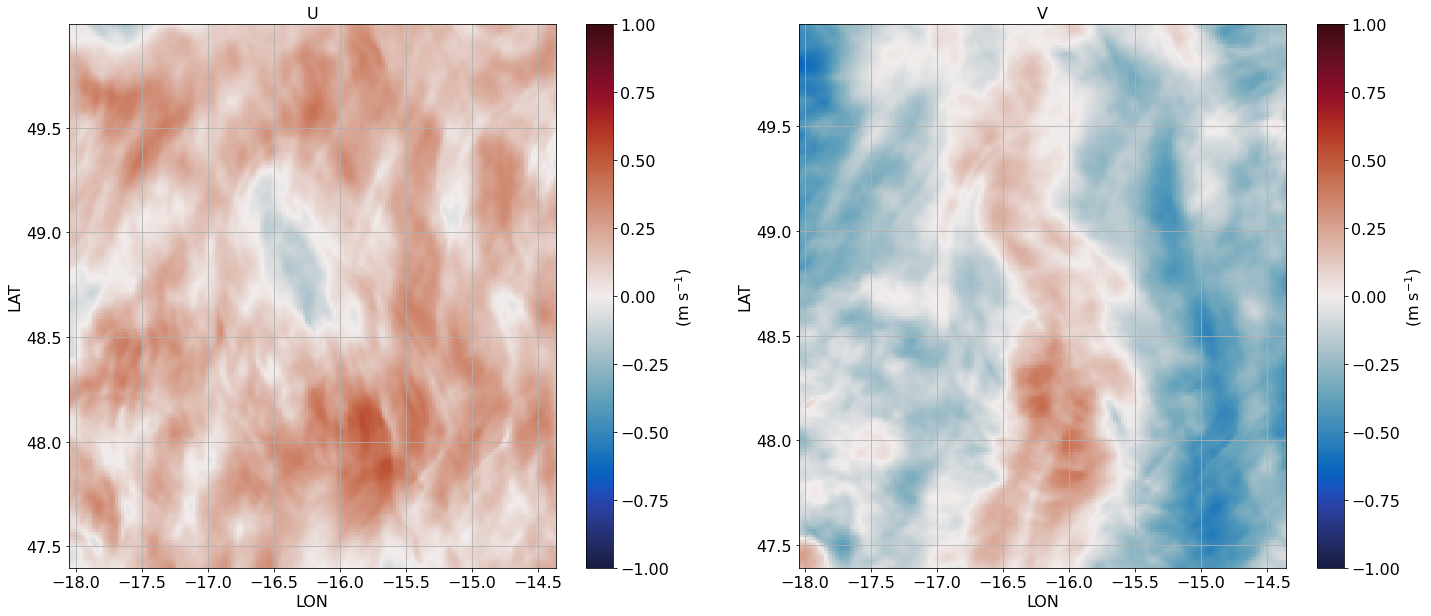

In [21]:
font_size = 16

fig, ax = plt.subplots(figsize=(24,10))

ax = plt.subplot(121)
cax = ds.U.plot(x='lon_g', y='lat',cmap=cm.balance, vmin=-1,vmax=1, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m s$^{-1}$)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.set_title('U',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(122)
cax = ds.V.plot(x='lon', y='lat_g',cmap=cm.balance, vmin=-1,vmax=1, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m s$^{-1}$)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.set_title('V',fontsize=font_size)
ax.tick_params(labelsize=font_size)

In [13]:
cluster.close()